<a href="https://colab.research.google.com/github/Jueunkim429/Cloud-cloud/blob/main/CutMix2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

In [41]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [27]:
# 학습 전에는 항상 GPU 환경을 확인
tf.config.list_physical_devices('GPU')

[]

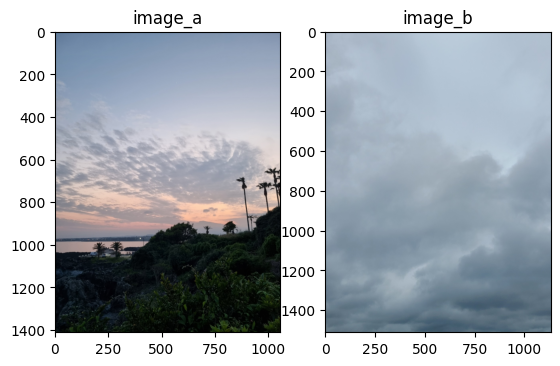

In [52]:
image_path = '/content/drive/MyDrive/cloud_data/'

index_len = len(os.listdir(image_path))
image_list = os.listdir(image_path)

def load_image(path, index):
    image = cv2.imread(os.path.join(path, image_list[index]), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    return image

image = load_image(image_path, 0)
image_size = image.shape[0]

image_a = cv2.imread(os.path.join(image_path, image_list[0]), cv2.IMREAD_COLOR)
image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB).astype(np.float32)
image_a /= 255.0

image_b = cv2.imread(os.path.join(image_path, image_list[3]), cv2.IMREAD_COLOR)
image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB).astype(np.float32)
image_b /= 255.0

plt.subplot(1,2,1)
plt.title("image_a")
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.title("image_b")
plt.imshow(image_b)

In [53]:
# 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b): 
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]   # width
    image_size_y = image_a.shape[0]   # height
    
    # 박스의 전체 영역을 가져오기
    x = tf.cast( tf.random.uniform([], minval=0, maxval=image_size_x), tf.int32)
    y = tf.cast( tf.random.uniform([], minval=0, maxval=image_size_y), tf.int32)

    # 박스의 너비와 높이를 가져오기
    width  = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)), tf.int32)
    
    # 이미지에서 박스를 자르고 최소 및 최대 바운딩 박스를 얻기
    xa = tf.math.maximum(0, x-width//2)        # get point starting in an area larger than 0       
    ya = tf.math.maximum(0, y-height//2)              
    xb = tf.math.minimum(image_size_x, x+width//2)   # get point ending in an area smaller than the image size
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(681, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(1058, shape=(), dtype=int32) tf.Tensor(508, shape=(), dtype=int32)


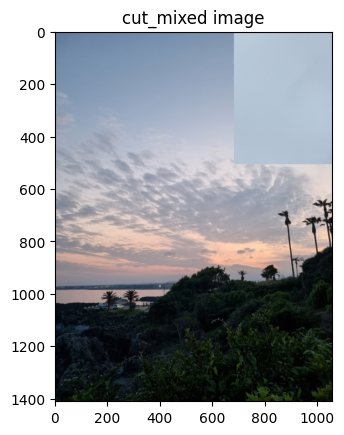

In [54]:
# 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    # 이미지를 다섯 부분으로 분할하여 영역을 결합
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    
    top = image_a[0:ya,:,:] # image_a의 첫 번째 행부터 ya 전까지의 행 가져오
    bottom = image_a[yb:image_size_y,:,:] # image_a의 yb 다음 행부터 마지막 행까지의 행 가져오기
    mixed_img = tf.concat([top, middle, bottom],axis=0) # top, middle, bottom을 세로로 연결한 텐서인 mixed_img를 생성
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)

plt.title("cut_mixed image")
plt.imshow(mixed_img.numpy())